# Result Analysis

*too: description*

In this notebook I analyse the results produced by running the experiment.

In [1]:
import logging
import os.path

import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import torch

from metrics.mae import MAE
from metrics.coverage_rate import CoverageRate, RollingCoverageRate, CoveredDimensions, RollingCoverageRateByFeature
from metrics.infinity_count import InfinityCount
from metrics.interval_width import MeanIntervalWidth

logging.basicConfig(level=logging.INFO, format='%(levelname)s %(filename)s:%(lineno)s %(funcName)s() %(message)s')

%pwd

In [2]:
experiment_group_dir = '../../../assets/experimental_results/exp_05_longelec2_rnn_wfct'
weight_functions_and_corrections = {
    'sol_icp_bf_exp_b0.007': 'sol_icp_bf_exponential_b0.007.json',
    'sol_icp_bf_sc_c200_s50': 'sol_icp_bf_soft_cutoff_c200_s50.json',
    'sol_icp_bf_lin': 'sol_icp_bf_linear.json',
    'sol_icp_bf_cst': 'sol_icp_bf_constant.json',
    'ol_icp_bf_cst': 'ol_icp_bf_constant.json'
}
univariate_and_multivariate_ds = {
    'multv': 'elec2_ds_multivariate.json',
}

fig_names = ['Exponential', 'Soft Cutoff', 'Linear', 'Constant', 'Off-Line\nConstant']

experiment_dirs = []
for icp_setting, icp_params_file in weight_functions_and_corrections.items():
    for ds_setting, ds_params_file in univariate_and_multivariate_ds.items():
        experiment_dirs.append(f'{ds_setting}_{icp_setting}')

output dirs

In [3]:
table_out_dir = Path(
    '/Users/filip.schlembach/Documents/uni/thesis_masters/latex/um_thesis_manuscript/tables/exp_05_longelec2_rnn_wfct')


def now() -> str:
    return datetime.datetime.now().strftime('%y%m%d_%H%M')

## MAE

In [4]:
mae_results = {exp_dir: MAE.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), MAE.snake_name())) for exp_dir in
    experiment_dirs}

print('underlying model mae on test set:', mae_results)

underlying model mae on test set: {'multv_sol_icp_bf_exp_b0.007': 0.07838670483120777, 'multv_sol_icp_bf_sc_c200_s50': 0.07925011413147909, 'multv_sol_icp_bf_lin': 0.07860028675893546, 'multv_sol_icp_bf_cst': 0.07931157660679619, 'multv_ol_icp_bf_cst': 0.07754465977155398}


Since they all perform more or less the same, I won't dive deeper into it.

## Coverage Rate

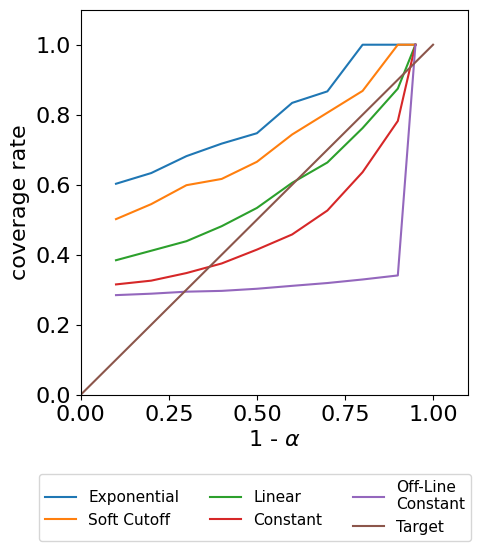

In [5]:
cr_results = [CoverageRate.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), CoverageRate.snake_name())) for exp_dir in
    experiment_dirs]
plt.rcParams.update({'font.size': 16})
CoverageRate.comparative_plot(cr_results, fig_names + ['Target'],
                              # save_path='comparison/' + CoverageRate.snake_name() + '.png'
                              fig_size=(5, 5))

In [6]:
cr_df = pd.DataFrame([[*cr_results[i][1]] for i in range(len(cr_results))], columns=1 - cr_results[0][0],
                     index=fig_names).T
cr_df = cr_df.round(decimals=3)
# cr_df.to_csv(table_out_dir / f'cr_{now()}.csv')
cr_df

,Exponential,Soft Cutoff,Linear,Constant,Off-Line\nConstant
0.10,0.603,0.502,0.384,0.315,0.285
0.20,0.633,0.545,0.411,0.326,0.289
0.30,0.682,0.599,0.439,0.348,0.294
0.40,0.717,0.617,0.482,0.375,0.297
0.50,0.747,0.665,0.534,0.415,0.303
0.60,0.834,0.743,0.605,0.458,0.311
0.70,0.867,0.806,0.663,0.526,0.319
0.80,1.000,0.868,0.762,0.636,0.329
0.90,1.000,1.000,0.875,0.782,0.341
0.95,1.000,1.000,1.000,1.000,1.000


### Rolling Coverage Rate

In [7]:
rcr_results = [RollingCoverageRate.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), RollingCoverageRate.snake_name())) for
    exp_dir in experiment_dirs]

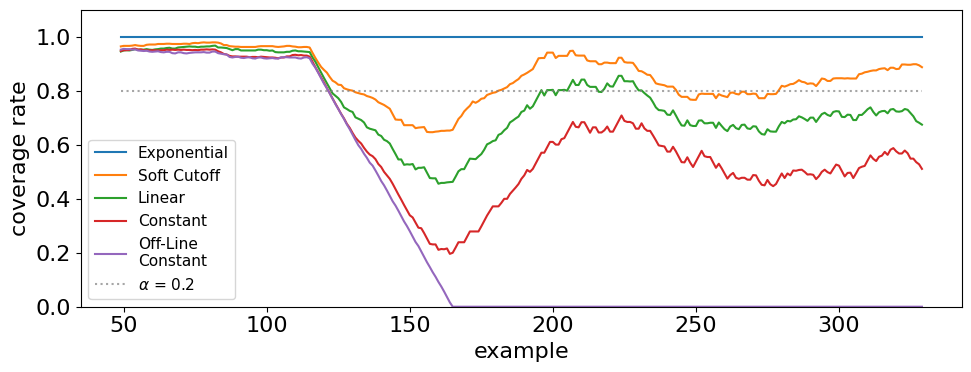

In [8]:
# for name, rcr_r in zip(fig_names, rcr_results):
#     RollingCoverageRate.simple_plot(rcr_r, name)
RollingCoverageRate.comparative_plot(rcr_results, fig_names, 0.2, fig_size=(10, 4))

### Rolling Coverage Rate by Feature

In [9]:
frcr_results = [RollingCoverageRateByFeature.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), RollingCoverageRateByFeature.snake_name()))
    for
    exp_dir in experiment_dirs]

In [10]:
rcr_by_feature = {f'feature_{i}': [] for i in range(3)}
for i in range(len(fig_names)):  # for every tested correction mehtod
    frcr_r_ex = frcr_results[i]
    for j in range(3):  # for every feature
        fcr_r_ex_f = (frcr_r_ex[0], frcr_r_ex[1][:, :, j], frcr_r_ex[2])
        rcr_by_feature[f'feature_{j}'].append(fcr_r_ex_f)

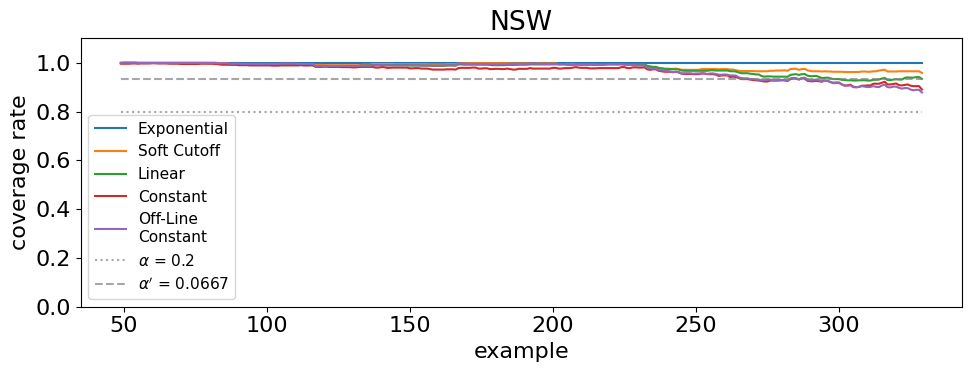

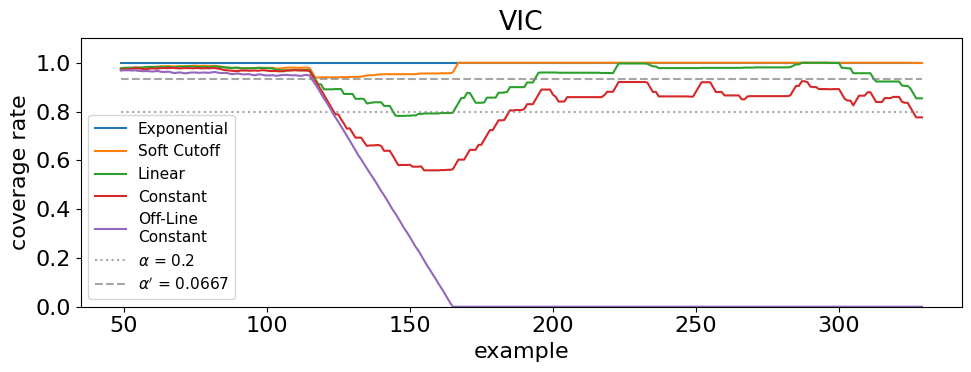

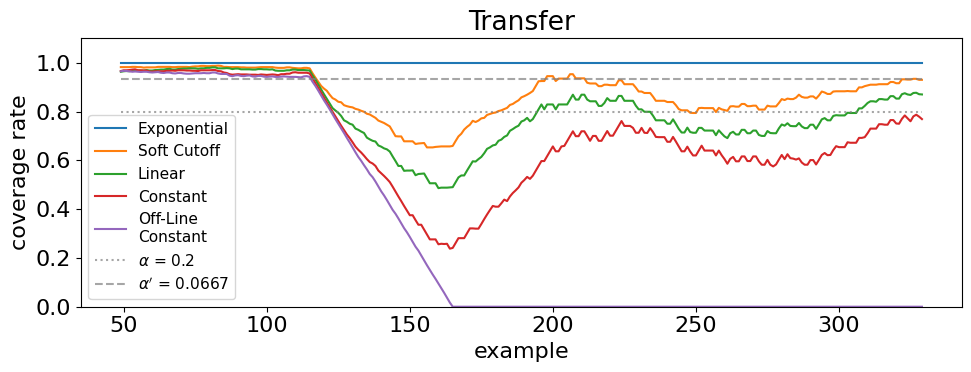

In [23]:
titles = ['NSW', 'VIC', 'Transfer']
for i in range(3):
    RollingCoverageRate.comparative_plot(rcr_by_feature[f'feature_{i}'], fig_names, 0.2, title=titles[i],
                                         fig_size=(10, 4), alpha_prime=0.2 / (3))

## Interval width

In [12]:
miw_results = [MeanIntervalWidth.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), MeanIntervalWidth.snake_name())) for exp_dir
    in
    experiment_dirs]

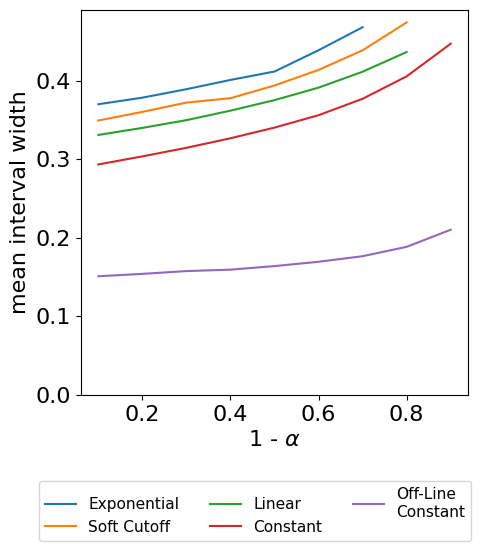

In [13]:
MeanIntervalWidth.comparative_plot(miw_results, fig_names,
                                   # save_path=os.path.join(experiment_group_dir,
                                   #                        f'comparison/{MeanIntervalWidth.snake_name()}.png')
                                   fig_size=(5, 5))

In [14]:
miw_df = pd.DataFrame([[*miw_results[i][1]] for i in range(len(miw_results))], columns=1 - miw_results[0][0],
                      index=fig_names).T
miw_df = miw_df.round(decimals=3)
# miw_df.to_csv(table_out_dir / f'miw_{now()}.csv')
miw_df

,Exponential,Soft Cutoff,Linear,Constant,Off-Line\nConstant
0.10,0.370,0.349,0.331,0.293,0.151
0.20,0.378,0.360,0.340,0.304,0.154
0.30,0.389,0.372,0.350,0.315,0.157
0.40,0.401,0.378,0.362,0.327,0.159
0.50,0.412,0.394,0.375,0.340,0.164
0.60,0.439,0.414,0.391,0.356,0.169
0.70,0.468,0.439,0.411,0.377,0.176
0.80,inf,0.474,0.437,0.406,0.188
0.90,inf,inf,inf,0.447,0.210
0.95,inf,inf,inf,inf,inf


## Covered Dimensions

In [15]:
cd_results = [CoveredDimensions.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), CoveredDimensions.snake_name())) for exp_dir
    in
    experiment_dirs]

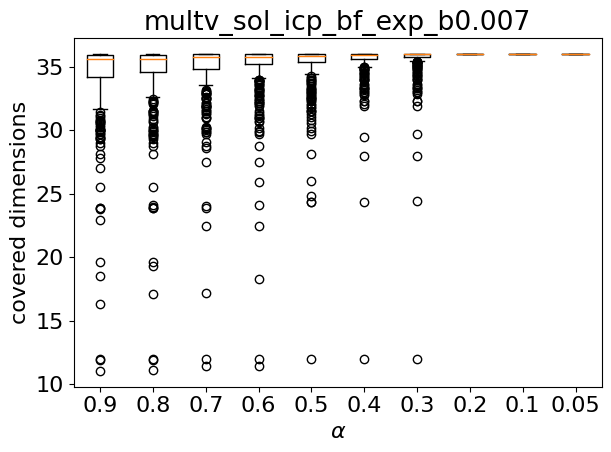

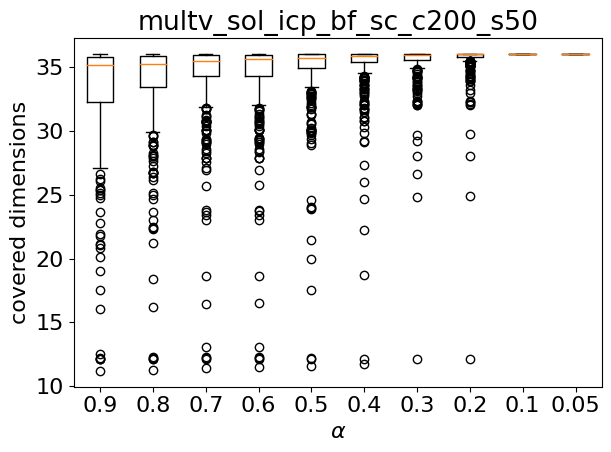

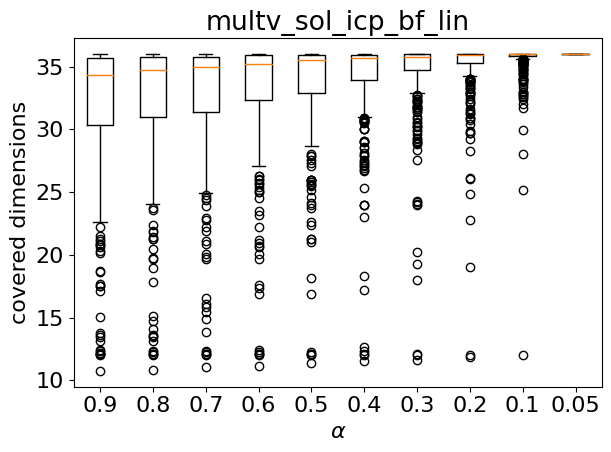

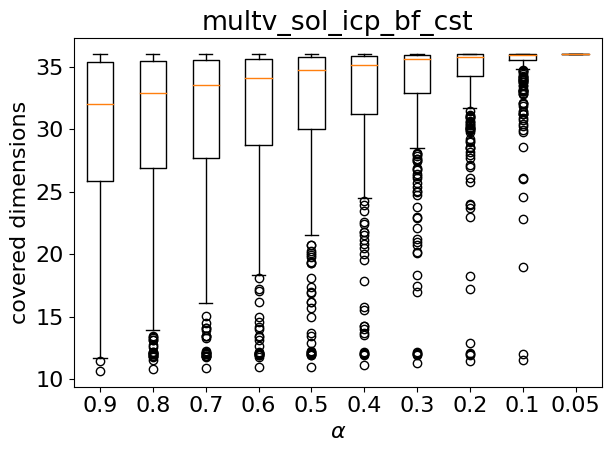

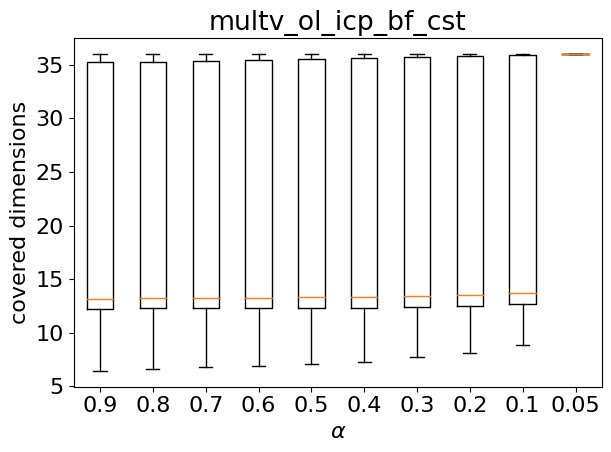

In [16]:
for i, cd_res in enumerate(cd_results):
    CoveredDimensions.simple_plot(cd_res, experiment_dirs[i])

## Infinite intervals

In [17]:
inf_count_results = [InfinityCount.load(
    os.path.join(os.path.join(experiment_group_dir, exp_dir + '/summary'), InfinityCount.snake_name())) for exp_dir
    in
    experiment_dirs]

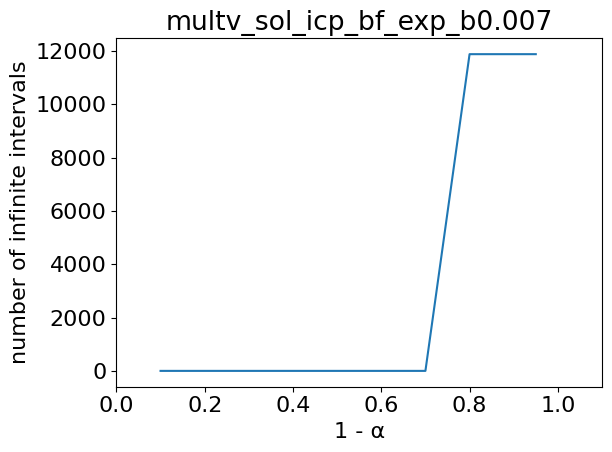

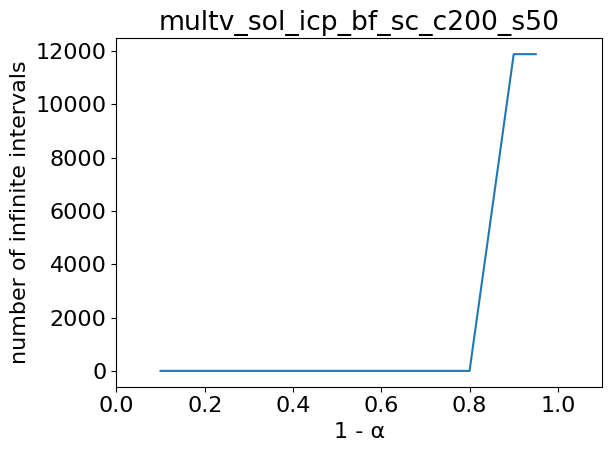

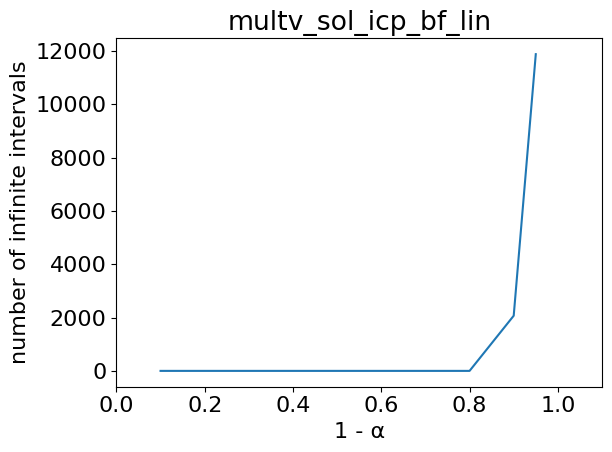

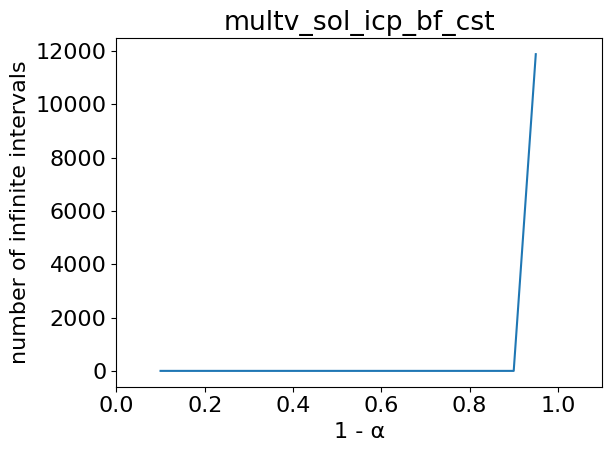

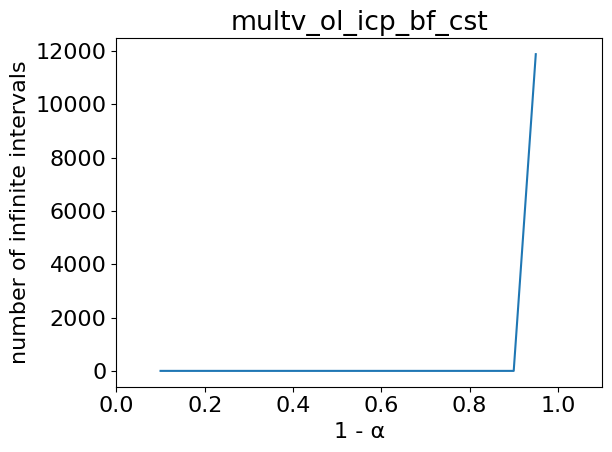

In [18]:
for i, inf_count_res in enumerate(inf_count_results):
    InfinityCount.simple_plot(inf_count_res, experiment_dirs[i])

## Weight function test

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from conformal_predictors.icp import ICP

INFO cp.py:219 get_soft_cutoff() factor: 0.5, cutoff: 200, softness: 50.0


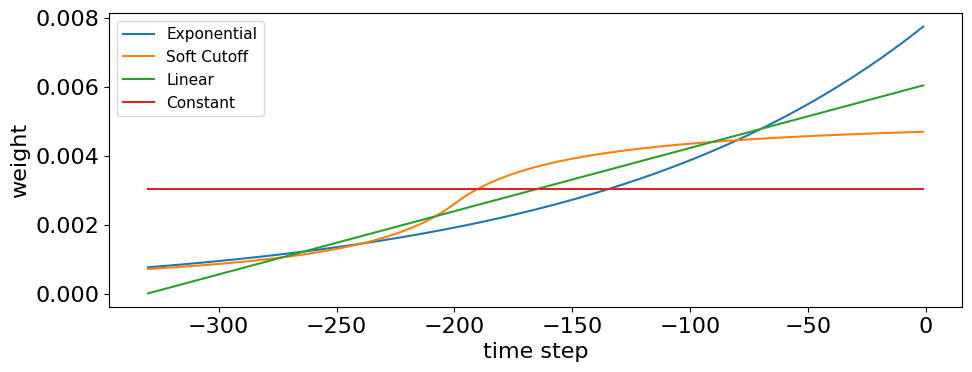

In [20]:
wf_f = {
    'Exponential': ICP.WeightFunctions.get_exponential(beta=0.007),
    'Soft Cutoff': ICP.WeightFunctions.get_soft_cutoff(0.5, 200, 50.),
    'Linear': ICP.WeightFunctions.get_linear(),
    'Constant': ICP.WeightFunctions.get_constant(1.)
}

wf = {}
time_steps = 330

for name in wf_f:
    wf[name] = wf_f[name](time_steps)
    wf[name] = wf[name] / np.sum(wf[name])

plt.figure(figsize=(10, 4))
for name in wf:
    plt.plot([t - time_steps for t in range(time_steps)], wf[name], label=name)
plt.xlabel('time step')
plt.ylabel('weight')
plt.legend(loc='upper left', ncol=1, fontsize='x-small')  # bbox_to_anchor=(1.22, 1.022),
plt.tight_layout()
plt.show()

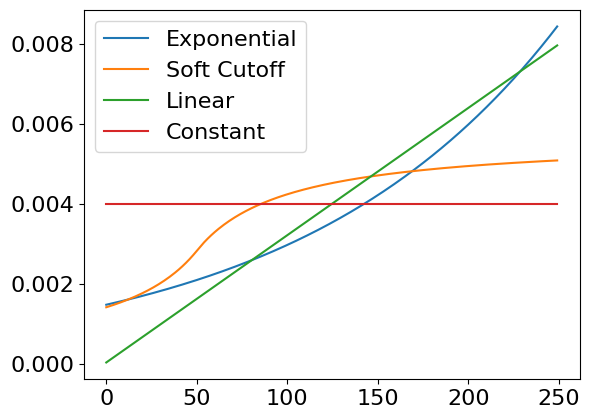

In [21]:
wf = {}

for name in wf_f:
    wf[name] = wf_f[name](250)
    wf[name] = wf[name] / np.sum(wf[name])

for name in wf:
    plt.plot(wf[name], label=name)
plt.legend()
plt.show()

## New metrics

- [x] Implement the aggregate method for the new metrics, i.e. check if the inherited one behaves well.
- [x] Compute the metrics for all trials and aggregates and save the results.
- [ ] Include the new metrics in the upper part of the notebook.

## Completeness

Since there have been issues with certain aspects of the execution in the past, I'm checking if all relevant files have been saved.
If there are missing files the experiment will have to be re-run.

In [22]:
from pathlib import Path

experiment_group_dir = Path(experiment_group_dir)
experiments = {}
for experiment_dir in experiment_group_dir.iterdir():
    if experiment_dir.is_dir():
        experiments[experiment_dir.name] = {}
        for trial_dir in experiment_dir.iterdir():
            if trial_dir.is_dir():
                experiments[experiment_dir.name][trial_dir.name] = {}
                for result_file in trial_dir.iterdir():
                    experiments[experiment_dir.name][trial_dir.name][result_file.name] = result_file.stat().st_ctime
                # experiments[experiment_dir.name][trial_dir.name]['_'] = np.NaN

        experiments[experiment_dir.name] = pd.DataFrame(experiments[experiment_dir.name])  # == 1
        experiments[experiment_dir.name] = experiments[experiment_dir.name].sort_index()
        experiments[experiment_dir.name] = experiments[experiment_dir.name].reindex(
            sorted(experiments[experiment_dir.name].columns), axis=1)

__Success__: All relevant files are present. The experiment does not need to be re-run.